In [1]:
import tarfile
import urllib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

Download and extract the TCGA dataset from UCI:

In [2]:
uci_tcga_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# Build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# Download the file
r = urllib.request.urlretrieve (full_download_url, archive_name)

# Extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

After the download and extraction is completed, you should have a directory that looks like this:

TCGA-PANCAN-HiSeq-801x20531/

|

├── data.csv

└── labels.csv

The KMeans class in scikit-learn requires a NumPy array as an argument. The NumPy package has a helper function to load the data from the text file into memory as NumPy arrays:

In [4]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"
data = np.genfromtxt(
       datafile,
       delimiter=",",
       usecols=range(1, 20532),
       skip_header=1
   )
  
true_label_names = np.genfromtxt(
       labels_file,
      delimiter=",",
       usecols=(1,),
       skip_header=1,
       dtype="str"
    )

Check out the first three columns of data for the first five samples as well as the labels for the first five samples:

In [5]:
data[:5, :3]

array([[0.        , 2.01720929, 3.26552691],
       [0.        , 0.59273209, 1.58842082],
       [0.        , 3.51175898, 4.32719872],
       [0.        , 3.66361787, 4.50764878],
       [0.        , 2.65574107, 2.82154696]])

In [6]:
true_label_names[:5]

array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype='<U4')

The data variable contains all the gene expression values from 20,531 genes. The true_label_names are the cancer types for each of the 881 samples. The first record in data corresponds with the first label in true_labels.

The labels are strings containing abbreviations of cancer types:

BRCA: Breast invasive carcinoma

COAD: Colon adenocarcinoma

KIRC: Kidney renal clear cell carcinoma

LUAD: Lung adenocarcinoma

PRAD: Prostate adenocarcinoma

To use these labels in the evaluation methods, you first need to convert the abbreviations to integers with LabelEncoder:

In [7]:
label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)

true_labels[:5]

array([4, 3, 4, 4, 0], dtype=int64)

Since the label_encoder has been fitted to the data, you can see the unique classes represented using .classes_. Store the length of the array to the variable n_clusters for later use:

In [9]:
label_encoder.classes_

n_clusters = len(label_encoder.classes_)

In practical machine learning pipelines, it’s common for the data to undergo multiple sequences of transformations before it feeds into a clustering algorithm. You learned about the importance of one of these transformation steps, feature scaling, earlier in this tutorial. An equally important data transformation technique is dimensionality reduction, which reduces the number of features in the dataset by either removing or combining them.

Dimensionality reduction techniques help to address a problem with machine learning algorithms known as the curse of dimensionality. In short, as the number of features increases, the feature space becomes sparse. This sparsity makes it difficult for algorithms to find data objects near one another in higher-dimensional space. Since the gene expression dataset has over 20,000 features, it qualifies as a great candidate for dimensionality reduction.

Principal Component Analysis (PCA) is one of many dimensionality reduction techniques. PCA transforms the input data by projecting it into a lower number of dimensions called components. The components capture the variability of the input data through a linear combination of the input data’s features.

The next code block introduces you to the concept of scikit-learn pipelines. The scikit-learn Pipeline class is a concrete implementation of the abstract idea of a machine learning pipeline.

Your gene expression data aren’t in the optimal format for the KMeans class, so you’ll need to build a preprocessing pipeline. The pipeline will implement an alternative to the StandardScaler class called MinMaxScaler for feature scaling. You use MinMaxScaler when you do not assume that the shape of all your features follows a normal distribution.

The next step in your preprocessing pipeline will implement the PCA class to perform dimensionality reduction:



In [10]:
preprocessor = Pipeline(
     [
          ("scaler", MinMaxScaler()),
          ("pca", PCA(n_components=2, random_state=42)),
     ]
   )

Now that you’ve built a pipeline to process the data, you’ll build a separate pipeline to perform k-means clustering. You’ll override the following default arguments of the KMeans class:

init: You’ll use "k-means++" instead of "random" to ensure centroids are initialized with some distance between them. In most cases, this will be an improvement over "random".

n_init: You’ll increase the number of initializations to ensure you find a stable solution.

max_iter: You’ll increase the number of iterations per initialization to ensure that k-means will converge.

Build the k-means clustering pipeline with user-defined arguments in the KMeans constructor:

In [11]:
clusterer = Pipeline(
    [
         (
              "kmeans",
             KMeans(
                  n_clusters=n_clusters,
                 init="k-means++",
                 n_init=50,
                  max_iter=500,
                  random_state=42,
              ),
         ),
       ]
    )

The Pipeline class can be chained to form a larger pipeline. Build an end-to-end k-means clustering pipeline by passing the "preprocessor" and "clusterer" pipelines to Pipeline:

In [12]:
pipe = Pipeline(
    [
           ("preprocessor", preprocessor),
           ("clusterer", clusterer)
       ]
    )

Calling .fit() with data as the argument performs all the pipeline steps on the data:

In [13]:
pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

The pipeline performs all the necessary steps to execute k-means clustering on the gene expression data! Depending on your Python REPL, .fit() may print a summary of the pipeline. Objects defined inside pipelines are accessible using their step name.

Evaluate the performance by calculating the silhouette coefficient:

In [15]:
preprocessed_data = pipe["preprocessor"].transform(data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)


0.5118775528450294

Calculate ARI, too, since the ground truth cluster labels are available:

In [16]:
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

As mentioned earlier, the scale for each of these clustering performance metrics ranges from -1 to 1. A silhouette coefficient of 0 indicates that clusters are significantly overlapping one another, and a silhouette coefficient of 1 indicates clusters are well-separated. An ARI score of 0 indicates that cluster labels are randomly assigned, and an ARI score of 1 means that the true labels and predicted labels form identical clusters.

Since you specified n_components=2 in the PCA step of the k-means clustering pipeline, you can also visualize the data in the context of the true labels and predicted labels. Plot the results using a pandas DataFrame and the seaborn plotting library:

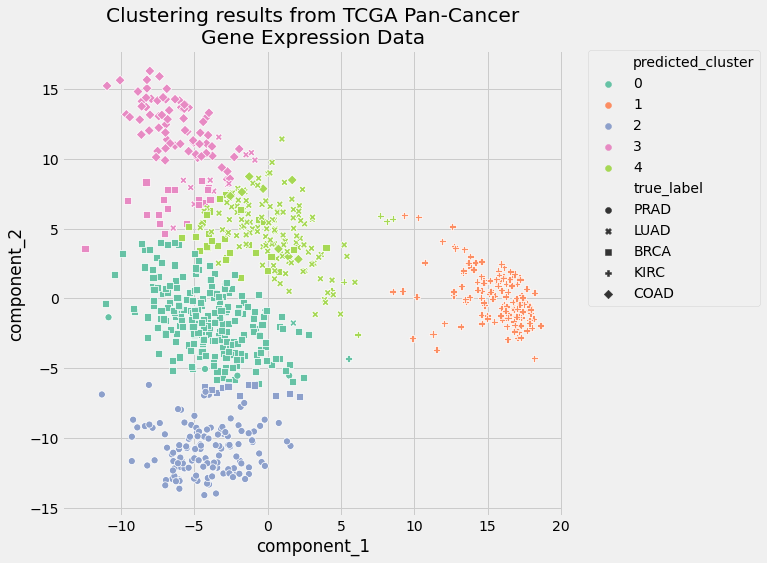

In [18]:
pcadf = pd.DataFrame(
      pipe["preprocessor"].transform(data),
       columns=["component_1", "component_2"],
    )
   
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))
scat = sns.scatterplot(
      "component_1",
       "component_2",
       s=50,
      data=pcadf,
        hue="predicted_cluster",
        style="true_label",
        palette="Set2",
   )
 
scat.set_title(
      "Clustering results from TCGA Pan-Cancer\nGene Expression Data"
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()